# Feature Engineering

This notebook creates the training dataset by merging three real datasets:
1. **Historical Crop Performance**: Actual yields per crop-province-year
2. **Soil Test Data**: Real farmer soil conditions (NPK, pH) aggregated by province
3. **Climate Data**: 5-year averages (2020-2024) for temperature, rainfall, humidity

Then:
- Extracts 9 features for each crop-province-soil combination
- Creates target suitability scores from actual historical yields
- Uses REAL data instead of simulated values


In [1]:
import pandas as pd
import numpy as np
import sys
import random
from pathlib import Path
from sklearn.model_selection import train_test_split

# Add app to path to import modules
project_root = Path("../").resolve()
sys.path.append(str(project_root))

from app.services.data_loader import DataLoader
from app.services.feature_extractor import FeatureExtractor
from app.utils.data_processor import normalize_npk_level, parse_ph_range, parse_soil_types

# Initialize with explicit data directory path
data_dir = project_root / "raw_datasets"
data_loader = DataLoader(data_dir=str(data_dir))
data_loader.load_all_data()
feature_extractor = FeatureExtractor()

print("Data loaded successfully!")


Loading datasets...
Loaded 117 crop climate requirements
Loaded 117 crop requirements
Loaded 117 NPK requirements
Loaded 94830 historical performance records
Loading climate data (this may take a moment)...


Loaded 215556 climate records
Creating unified crop database...
Unified database created with 117 crops
Data loaded successfully!


In [2]:
# Load historical performance and calculate yields
historical_perf = pd.read_csv("../raw_datasets/historical_crop_performance.csv")
historical_perf['yield_per_ha'] = (
    historical_perf['Volume_Production'] / historical_perf['Area_Planted_Harvested']
)

# Clean data
historical_perf_clean = historical_perf[
    (historical_perf['yield_per_ha'].notna()) & 
    (historical_perf['yield_per_ha'] != float('inf')) &
    (historical_perf['yield_per_ha'] > 0)
].copy()

print(f"Valid yield records: {len(historical_perf_clean)}")


Valid yield records: 94830


In [3]:
# Load and aggregate soil test data
print("Loading soil test data...")
soil_test_df = pd.read_csv("../raw_datasets/soil_test_data.csv")
print(f"Loaded {len(soil_test_df)} soil test records")

# Normalize province names for matching
soil_test_df['province_normalized'] = soil_test_df['province'].str.strip().str.title()

# Aggregate soil data by province (get most common values)
def get_mode_or_default(series, default='Medium'):
    """Get mode value or return default if empty."""
    mode_values = series.mode()
    return mode_values[0] if len(mode_values) > 0 else default

province_soil_agg = soil_test_df.groupby('province_normalized').agg({
    'nitrogen': lambda x: get_mode_or_default(x, 'Medium'),
    'phosphorus': lambda x: get_mode_or_default(x, 'Medium'),
    'potassium': lambda x: get_mode_or_default(x, 'Medium'),
    'ph_min': 'mean',
    'ph_max': 'mean'
}).reset_index()
province_soil_agg.columns = ['province', 'nitrogen', 'phosphorus', 'potassium', 'ph_min', 'ph_max']

print(f"Aggregated soil data for {len(province_soil_agg)} provinces")

# Normalize province names in historical data for merging
historical_perf_clean['Province_normalized'] = historical_perf_clean['Province'].str.strip().str.title()

# Merge historical performance with soil data
print("\nMerging historical data with soil data...")
merged_data = historical_perf_clean.merge(
    province_soil_agg,
    left_on='Province_normalized',
    right_on='province',
    how='inner'  # Only keep records with soil data
)

print(f"Total merged records: {len(merged_data)}")
print(f"Records with soil data: {merged_data['nitrogen'].notna().sum()}")
print(f"Unique crop-province combinations with soil data: {merged_data[['Crop', 'Province']].drop_duplicates().shape[0]}")


Loading soil test data...
Loaded 22242 soil test records
Aggregated soil data for 62 provinces

Merging historical data with soil data...
Total merged records: 67142
Records with soil data: 67142
Unique crop-province combinations with soil data: 3804


In [4]:
merged_data.head()

,Crop,Province,Year,Volume_Production,Area_Planted_Harvested,yield_per_ha,Province_normalized,province,nitrogen,phosphorus,potassium,ph_min,ph_max
0,Alugbati,Abra,2023,0.75,0.92,0.815217,Abra,Abra,Low,Low,Low,6.026508,7.296770
1,Alugbati,Abra,2024,0.51,1.00,0.510000,Abra,Abra,Low,Low,Low,6.026508,7.296770
2,Alugbati,Agusan del Norte,2010,48.65,12.00,4.054167,Agusan Del Norte,Agusan Del Norte,High,Low,Medium,5.833333,7.064912
3,Alugbati,Agusan del Norte,2011,45.85,10.00,4.585000,Agusan Del Norte,Agusan Del Norte,High,Low,Medium,5.833333,7.064912
4,Alugbati,Agusan del Norte,2012,42.00,9.50,4.421053,Agusan Del Norte,Agusan Del Norte,High,Low,Medium,5.833333,7.064912


In [5]:
# Calculate the 95th percentile yield for each crop
max_yield_per_crop = historical_perf_clean.groupby('Crop')['yield_per_ha'].quantile(0.95)

# Create training dataset using the entire merged dataset
training_data = []

print(f"Processing {len(merged_data)} records for all 12 months...")

# Loop through each historical record
for idx, row in merged_data.iterrows():
    crop_name = row['Crop']
    province = row['Province']
    yield_per_ha = row['yield_per_ha']
    
    try:
        # Get crop and climate data once per row
        crop_data = data_loader.get_crop_by_name(crop_name)
        if crop_data is None:
            continue

        # Use a realistic soil type
        acceptable_soils = parse_soil_types(crop_data.get('Acceptable_Soil_Types', 'Loam'))
        farmer_soil_type = random.choice(acceptable_soils) if acceptable_soils else 'Loam'

        # Iterate over all 12 months for each record
        for month in range(1, 13):
            # Get monthly climate averages
            climate = data_loader.get_climate_averages(province, month)
            if not all([climate['temperature'], climate['rainfall'], climate['humidity']]):
                continue

            # Extract features for the current month
            features = feature_extractor.extract_features(
                crop_data=crop_data,
                farmer_nitrogen=str(row['nitrogen']),
                farmer_phosphorus=str(row['phosphorus']),
                farmer_potassium=str(row['potassium']),
                farmer_ph_min=float(row['ph_min']),
                farmer_ph_max=float(row['ph_max']),
                farmer_soil_type=farmer_soil_type,
                avg_temperature=climate['temperature'],
                avg_rainfall=climate['rainfall'],
                avg_humidity=climate['humidity'],
                historical_yield_data=data_loader.get_historical_yield(crop_name, province),
                current_month=month
            )

            # Dynamic suitability score based on historical yield
            max_yield = max_yield_per_crop.get(crop_name, 20)  # Default if not found
            suitability_score = min(100.0, max(0.0, (yield_per_ha / max_yield) * 80.0 + 20.0))

            # Create the training row
            training_row = features.copy()
            training_row['suitability_score'] = suitability_score
            training_row['month'] = month  # Add month to the features
            training_row['crop_name'] = crop_name
            training_row['province'] = province
            training_row['category'] = crop_data.get('Category', 'Unknown')
            training_row['actual_yield'] = yield_per_ha
            
            training_data.append(training_row)

    except Exception as e:
        # Continue to the next record if an error occurs
        continue

    # Progress indicator
    if (idx + 1) % 1000 == 0:
        print(f"Processed {idx + 1}/{len(merged_data)} historical records, created {len(training_data)} training rows...")

print(f"\nTotal training records created: {len(training_data)}")


Processing 67142 records for all 12 months...


Processed 1000/67142 historical records, created 11868 training rows...


Processed 2000/67142 historical records, created 23808 training rows...


Processed 3000/67142 historical records, created 35688 training rows...


Processed 4000/67142 historical records, created 47628 training rows...


Processed 13000/67142 historical records, created 56748 training rows...


Processed 15000/67142 historical records, created 74880 training rows...


Processed 17000/67142 historical records, created 79116 training rows...


Processed 18000/67142 historical records, created 82224 training rows...


Processed 23000/67142 historical records, created 95976 training rows...


Processed 25000/67142 historical records, created 109500 training rows...


Processed 29000/67142 historical records, created 119388 training rows...


Processed 31000/67142 historical records, created 133308 training rows...


Processed 32000/67142 historical records, created 145188 training rows...


Processed 33000/67142 historical records, created 157188 training rows...


Processed 35000/67142 historical records, created 177240 training rows...


Processed 36000/67142 historical records, created 189168 training rows...


Processed 37000/67142 historical records, created 201108 training rows...


Processed 38000/67142 historical records, created 212976 training rows...


Processed 39000/67142 historical records, created 224880 training rows...


Processed 40000/67142 historical records, created 236076 training rows...


Processed 41000/67142 historical records, created 248076 training rows...


Processed 43000/67142 historical records, created 257244 training rows...


Processed 44000/67142 historical records, created 269220 training rows...


Processed 45000/67142 historical records, created 281148 training rows...


Processed 48000/67142 historical records, created 287940 training rows...


Processed 50000/67142 historical records, created 301716 training rows...


Processed 51000/67142 historical records, created 313572 training rows...


Processed 55000/67142 historical records, created 324648 training rows...


Processed 56000/67142 historical records, created 334908 training rows...


Processed 57000/67142 historical records, created 346632 training rows...


Processed 58000/67142 historical records, created 358572 training rows...


Processed 59000/67142 historical records, created 370512 training rows...


Processed 60000/67142 historical records, created 382512 training rows...


Processed 61000/67142 historical records, created 394452 training rows...


Processed 63000/67142 historical records, created 410664 training rows...


Processed 65000/67142 historical records, created 424272 training rows...


Processed 66000/67142 historical records, created 436200 training rows...


Processed 67000/67142 historical records, created 448128 training rows...



Total training records created: 449352


In [6]:
# Convert to DataFrame
train_df = pd.DataFrame(training_data)
print("Full dataset shape:", train_df.shape)

# Split data into training and validation sets
train_set, val_set = train_test_split(train_df, test_size=0.2, random_state=42)

print(f"Training set shape: {train_set.shape}")
print(f"Validation set shape: {val_set.shape}")

# Save the datasets
output_dir = Path("../models")
train_set.to_csv(output_dir / "training_dataset.csv", index=False)
val_set.to_csv(output_dir / "validation_dataset.csv", index=False)

print("\nTraining and validation datasets saved successfully!")


Full dataset shape: (449352, 15)
Training set shape: (359481, 15)
Validation set shape: (89871, 15)



Training and validation datasets saved successfully!


In [8]:
import pandas as pd

In [9]:
train_df = pd.read_csv("../models/training_dataset.csv")
val_df = pd.read_csv("../models/validation_dataset.csv")

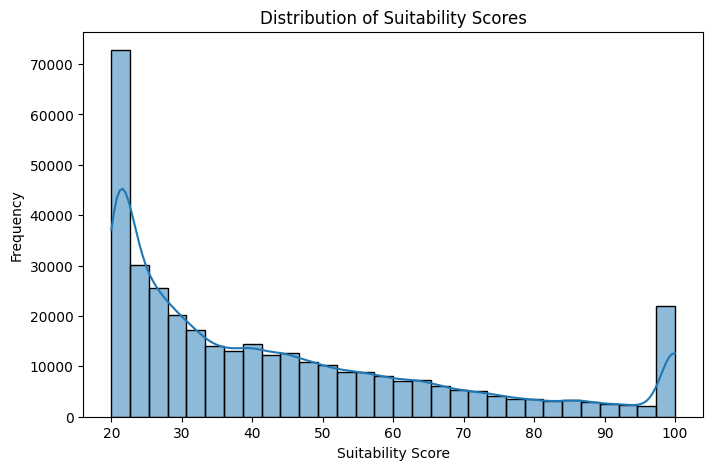

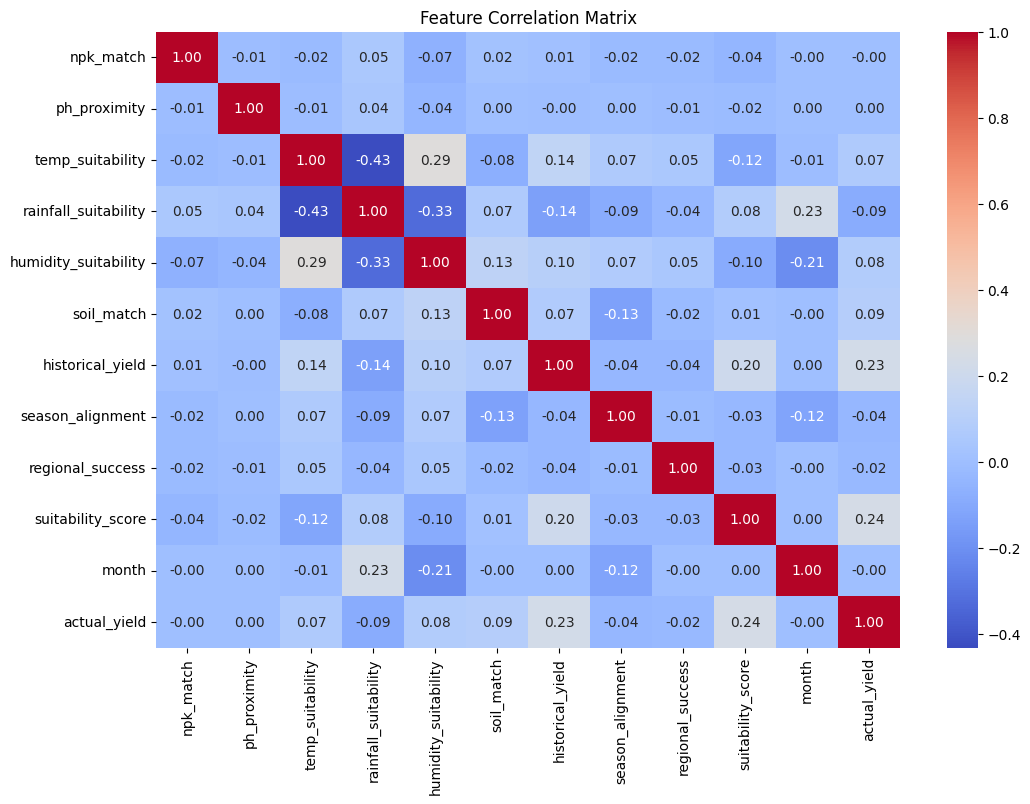

In [12]:
import seaborn as sns

import matplotlib.pyplot as plt

# Visualize distribution of suitability scores
plt.figure(figsize=(8, 5))
sns.histplot(train_df['suitability_score'], bins=30, kde=True)
plt.title('Distribution of Suitability Scores')
plt.xlabel('Suitability Score')
plt.ylabel('Frequency')
plt.show()

# Visualize feature correlations
plt.figure(figsize=(12, 8))
corr = train_df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Matrix')
plt.show()